# Download and prepare dataset

In [ ]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path):
  return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
  return ''.join(
      c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn'
      and c in all_letters
  )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
  lines = open(filename, encoding='UTF-8').read().strip().split('\n')
  return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
  category = os.path.splitext(os.path.basename(filename))[0]
  all_categories.append(category)
  lines = readLines(filename)
  category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Polish.txt', 'data/names/German.txt', 'data/names/Czech.txt', 'data/names/Scottish.txt', 'data/names/Japanese.txt', 'data/names/Italian.txt', 'data/names/Chinese.txt', 'data/names/Russian.txt', 'data/names/Portuguese.txt', 'data/names/Irish.txt', 'data/names/Dutch.txt', 'data/names/Vietnamese.txt', 'data/names/Arabic.txt', 'data/names/Korean.txt', 'data/names/English.txt', 'data/names/French.txt', 'data/names/Spanish.txt', 'data/names/Greek.txt']
Slusarski


In [3]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


# Turning name in tensor

In [4]:
import torch

def letterToIdx(letter):
  return all_letters.find(letter)

# We actually don't use this
def letterToTensor(letter):
  tensor = torch.zeros(1, n_letters)
  tensor[0][letterToIdx(letter)] = 1
  return tensor # one hot vector

# Turn a line: Abandonato into Tensor of shape: [num_char_in_line, 1, n_letters]
def lineToTensor(line):
  tensor = torch.zeros(len(line), 1, n_letters)
  for line_idx, letter in enumerate(line):
    tensor[line_idx][0][letterToIdx(letter)] = 1
  return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


# Creating the network

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(RNN, self).__init__()
    self.hidden_size = hidden_size
    
    self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
    self.i2o = nn.Linear(input_size + hidden_size, output_size)

  def init_hidden(self):
    return torch.zeros(1, self.hidden_size)

  def forward(self, input, hidden):
    combined = torch.cat((input, hidden) , 1)
    hidden = self.i2h(combined)
    output = self.i2o(combined)
    output = F.log_softmax(output, dim=1)
    return output, hidden

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [10]:
input = letterToTensor('A')
hidden = rnn.init_hidden()

with torch.no_grad():
  output, next_hidden = rnn(input, hidden)
print(output)
print(next_hidden)

tensor([[-2.8402, -2.9274, -2.8994, -2.8556, -3.0209, -2.7966, -2.9589, -2.9114,
         -2.9345, -2.8402, -2.9200, -2.8372, -2.9322, -2.8463, -2.8715, -2.8976,
         -2.9913, -2.7806]])
tensor([[ 5.8985e-02, -1.1291e-02, -4.1824e-02, -6.4282e-02,  2.4660e-02,
         -1.1473e-01,  3.5859e-02, -3.2638e-02,  6.3994e-02,  3.3924e-02,
          2.5085e-02,  4.6567e-03,  4.0549e-02,  1.1328e-01,  5.0712e-02,
          5.6844e-02,  2.9481e-02,  3.8077e-02, -5.8498e-02,  3.7190e-02,
          5.0150e-05, -1.0731e-01, -5.6037e-02, -2.4882e-02,  8.1689e-02,
          1.0756e-01, -8.0525e-03, -1.5084e-02,  1.6585e-02,  4.5512e-02,
          5.2777e-02,  7.9954e-02,  4.6754e-02,  6.0379e-02,  2.3662e-02,
          3.2974e-02, -7.0316e-02,  6.1280e-02,  6.4800e-02,  3.1320e-02,
          3.9467e-02,  3.2924e-02, -2.5343e-02, -1.1001e-02, -4.2726e-02,
          1.2725e-01,  7.4832e-02,  1.0770e-01, -3.3840e-02, -3.4960e-03,
          3.3608e-02, -8.4123e-02, -3.5485e-02,  2.8162e-02,  2.0806e

In [11]:
input = lineToTensor('Albert')
hidden = rnn.init_hidden()

with torch.no_grad():
  output, next_hidden= rnn(input[0], hidden)
print(output)
print(next_hidden)

tensor([[-2.8402, -2.9274, -2.8994, -2.8556, -3.0209, -2.7966, -2.9589, -2.9114,
         -2.9345, -2.8402, -2.9200, -2.8372, -2.9322, -2.8463, -2.8715, -2.8976,
         -2.9913, -2.7806]])
tensor([[ 5.8985e-02, -1.1291e-02, -4.1824e-02, -6.4282e-02,  2.4660e-02,
         -1.1473e-01,  3.5859e-02, -3.2638e-02,  6.3994e-02,  3.3924e-02,
          2.5085e-02,  4.6567e-03,  4.0549e-02,  1.1328e-01,  5.0712e-02,
          5.6844e-02,  2.9481e-02,  3.8077e-02, -5.8498e-02,  3.7190e-02,
          5.0150e-05, -1.0731e-01, -5.6037e-02, -2.4882e-02,  8.1689e-02,
          1.0756e-01, -8.0525e-03, -1.5084e-02,  1.6585e-02,  4.5512e-02,
          5.2777e-02,  7.9954e-02,  4.6754e-02,  6.0379e-02,  2.3662e-02,
          3.2974e-02, -7.0316e-02,  6.1280e-02,  6.4800e-02,  3.1320e-02,
          3.9467e-02,  3.2924e-02, -2.5343e-02, -1.1001e-02, -4.2726e-02,
          1.2725e-01,  7.4832e-02,  1.0770e-01, -3.3840e-02, -3.4960e-03,
          3.3608e-02, -8.4123e-02, -3.5485e-02,  2.8162e-02,  2.0806e

# Training

In [12]:
def categoryFromOutput(output):
  _, top_i = output.topk(1)
  category_i = top_i[0].item()
  return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Greek', 17)


In [14]:
import random

def randomChoice(l):
  return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
  category = randomChoice(all_categories)
  line = randomChoice(category_lines[category])
  category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
  line_tensor = lineToTensor(line)
  return category, line, category_tensor, line_tensor

for i in range(10):
  category, line, category_tensor, line_tensor = randomTrainingExample()
  print('category=', category, '/ line =', line)

category= Portuguese / line = Araujo
category= Italian / line = Potenza
category= English / line = Danks
category= French / line = Robert
category= Arabic / line = Assaf
category= Vietnamese / line = Phi
category= Chinese / line = Dong
category= Scottish / line = Gray
category= English / line = Goodchild
category= Scottish / line = Douglas


# Training

In [15]:
criterion = nn.NLLLoss()

In [22]:
learning_rate = 0.005

def train(category_tensor, line_tensor):
  hidden = rnn.init_hidden()

  rnn.zero_grad()

  for i in range(line_tensor.size()[0]):
    output, hidden = rnn(line_tensor[i], hidden)

  loss = criterion(output, category_tensor)
  loss.backward()

  for p in rnn.parameters():
    p.data.add_(p.grad.data, alpha=-learning_rate)
  
  return output, loss.item()

In [23]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

def timeSince(since):
  now = time.time()
  s = now - since
  m = math.floor(s / 60)
  s -= m * 60
  return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
  category, line, category_tensor, line_tensor = randomTrainingExample()
  output, loss = train(category_tensor, line_tensor)
  current_loss += loss

  if iter % print_every == 0:
    guess, guess_i = categoryFromOutput(output)
    correct = '✓' if guess == category else '✗ (%s)' % category
    print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100,
                                            timeSince(start), loss, line, guess,
                                            correct))
  if iter % plot_every == 0:
    all_losses.append(current_loss / plot_every)
    current_loss = 0

5000 5% (0m 4s) 2.7383 O'Neill / Dutch ✗ (Irish)
10000 10% (0m 9s) 2.4352 Araujo / Portuguese ✗ (Spanish)
15000 15% (0m 14s) 2.3601 Sze  / Korean ✗ (Chinese)
20000 20% (0m 19s) 2.2354 Sakellariou / Scottish ✗ (Greek)
25000 25% (0m 24s) 3.4521 Latham / Arabic ✗ (English)
30000 30% (0m 29s) 3.0382 Romeijn / Irish ✗ (Dutch)
35000 35% (0m 33s) 4.1045 Bondesan / Scottish ✗ (Italian)
40000 40% (0m 38s) 1.7171 Sansone / French ✗ (Italian)
45000 45% (0m 43s) 1.2416 Marie / French ✓
50000 50% (0m 48s) 2.0478 Langbroek / French ✗ (Dutch)
55000 55% (0m 52s) 1.6134 Mckenzie / Russian ✗ (Scottish)
60000 60% (0m 57s) 0.3865 Dam / Vietnamese ✓
65000 65% (1m 2s) 0.7308 Gonzalez / Spanish ✓
70000 70% (1m 7s) 2.9189 Arthur / Arabic ✗ (French)
75000 75% (1m 11s) 1.2856 Nigro / Portuguese ✗ (Italian)
80000 80% (1m 16s) 2.5812 Garb / Arabic ✗ (German)
85000 85% (1m 21s) 3.3537 Sierzant / Dutch ✗ (Polish)
90000 90% (1m 26s) 1.5503 Montero / Portuguese ✗ (Spanish)
95000 95% (1m 30s) 1.1692 Ton / Chinese ✗ (V

# Plot the results

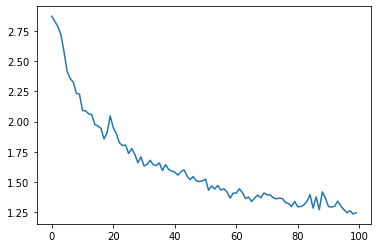

In [24]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

# Evaluating the results

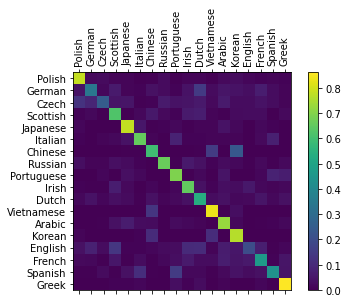

In [26]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

def evaluate(line_tensor):
  hidden = rnn.init_hidden()

  for i in range(line_tensor.size()[0]):
    output, hidden = rnn(line_tensor[i], hidden)
  
  return output

for i in range(n_confusion):
  category, line, category_tensor, line_tensor = randomTrainingExample()
  output = evaluate(line_tensor)
  guess, guess_i = categoryFromOutput(output)
  category_i = all_categories.index(category)
  confusion[category_i][guess_i] += 1

for i in range(n_categories):
  confusion[i] = confusion[i] / confusion[i].sum()

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + all_categories, rotation = 90)
ax.set_yticklabels([''] + all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

# Running on User Input

In [27]:
def predict(input_line, n_predictions=3):
  print('\n %s' % input_line)
  with torch.no_grad():
    output = evaluate(lineToTensor(input_line))

    topv, topi = output.topk(n_predictions, 1, True)
    predictions = []

    for i in range(n_predictions):
      value = topv[0][i].item()
      category_index = topi[0][i].item()
      print('(%.2f) %s' % (value, all_categories[category_index]))
      predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


 Dovesky
(-0.42) Russian
(-1.36) Czech
(-3.52) English

 Jackson
(-0.13) Scottish
(-2.87) English
(-3.73) Russian

 Satoshi
(-0.44) Japanese
(-1.59) Arabic
(-2.78) Italian
